In [60]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import os
from reload_recursive import reload_recursive
import helpers
import pyperclip
import statsmodels.api as sm

from mri_data import file_manager as fm
from mri_data import utils

In [61]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path("/home/srs-9/Projects/ms_mri/analysis/paper1")
data_dir = curr_dir / "data0"
showfigs = False
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.precision = 3

In [ ]:
df1 = pd.read_csv(data_dir / "t1_data_full.csv")
df1.set_index('subid', inplace=True)
df1 = helpers.set_dz_type5(df1)

df2 = pd.read_csv(data_dir / "t1_2_data_full.csv")
df2.set_index('subid', inplace=True)
df2 = helpers.set_dz_type5(df2)

df3 = pd.read_csv(data_dir / "t1_3_data_full.csv")
df3.set_index('subid', inplace=True)
df3 = helpers.set_dz_type5(df3)

df_flair = pd.read_csv(data_dir / "flair_data_full.csv")
df_flair.set_index('subid', inplace=True)
df_flair = helpers.set_dz_type5(df_flair)

(array([  1.,  18.,  35.,  58., 112.,  89.,  59.,  29.,   6.,   3.]),
 array([ 351.715973 ,  692.1555085, 1032.595044 , 1373.0345795,
        1713.474115 , 2053.9136505, 2394.353186 , 2734.7927215,
        3075.232257 , 3415.6717925, 3756.111328 ]),
 <BarContainer object of 10 artists>)

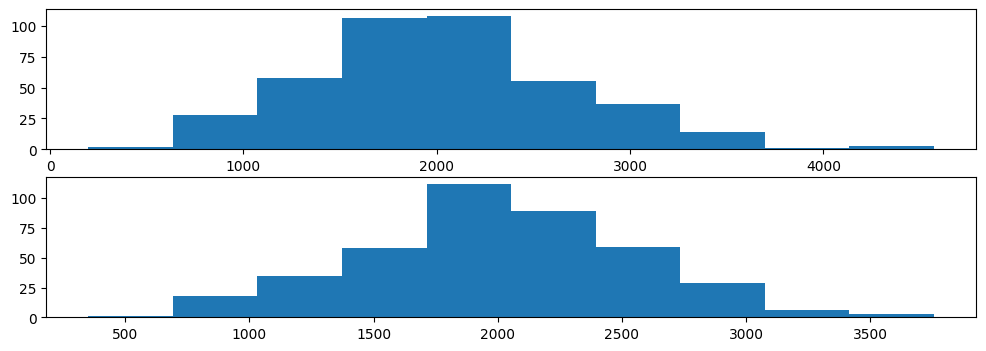

In [63]:
fig, axs = plt.subplots(2,1,figsize=(12, 4))

axs[0].hist(df1.loc[df1['dz_type5'].isin(["RMS", "PMS"]), 'choroid_volume'])
axs[1].hist(df3.loc[df2['dz_type5'].isin(["RMS", "PMS"]), 'choroid_volume'])

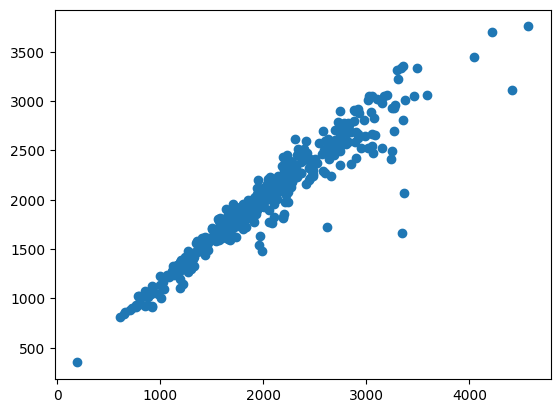

In [64]:
plt.scatter(df1.loc[df1['dz_type5'].isin(["RMS", "PMS"]), 'choroid_volume'], 
            df3.loc[df3['dz_type5'].isin(["RMS", "PMS"]), 'choroid_volume'])

(array([52., 18.,  9.,  3.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([ -12.287719 ,  156.1086433,  324.5050056,  492.9013679,
         661.2977302,  829.6940925,  998.0904548, 1166.4868171,
        1334.8831794, 1503.2795417, 1671.675904 ]),
 <BarContainer object of 10 artists>)

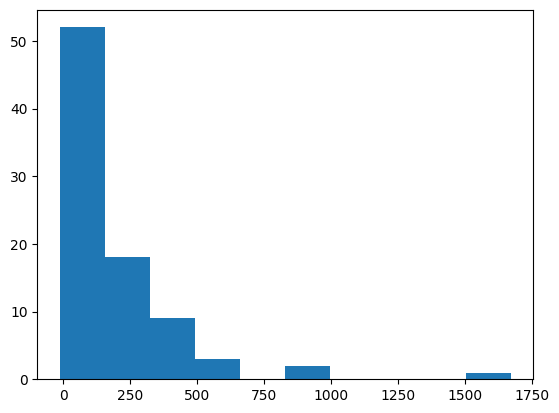

In [65]:
plt.hist((df1.loc[df1['dz_type5'].isin(["PMS"]), 'choroid_volume'] - df2.loc[df2['dz_type5'].isin(["PMS"]), 'choroid_volume']))

In [89]:
df = pd.DataFrame(index=df1.index)
df['choroid_volume1'] = df1['choroid_volume']
df['choroid_volume2'] = df2['choroid_volume']
df['choroid_volume_fl'] = df_flair['choroid_volume']
df['cp_diff'] = df['choroid_volume1'] - df['choroid_volume2']
df['dz_type5'] = df1['dz_type5']

In [90]:
df = df.sort_values(by="choroid_volume1", ascending=False)
df_pms = df[df['dz_type5']=="PMS"]

In [93]:
sub = 1370

dataroot = drive_root / "3Tpioneer_bids"
labelroot = drive_root / "srs-9/3Tpioneer_bids_predictions"
label1 = labelroot / df1.loc[sub, 'sub-ses'] / df1.loc[sub, 'label']
label2 = labelroot / df2.loc[sub, 'sub-ses'] / df2.loc[sub, 'label']
label_flair = labelroot / df_flair.loc[sub, 'sub-ses'] / df_flair.loc[sub, 'label']
t1 = dataroot / df1.loc[sub, 'sub-ses'] / "t1.nii.gz"
flair = dataroot / df1.loc[sub, 'sub-ses'] / "flair.nii.gz"
t1_gd = dataroot / df1.loc[sub, 'sub-ses'] / "t1_gd.nii.gz"

cmd = utils.open_itksnap_workspace_cmd(images=[t1, flair], labels=[label1, label2, label_flair], win=True)
pyperclip.copy(cmd)
print(cmd)

itksnap -g H:/3Tpioneer_bids/sub-ms1370/ses-20210421/t1.nii.gz -o H:/3Tpioneer_bids/sub-ms1370/ses-20210421/flair.nii.gz -s H:/srs-9/3Tpioneer_bids_predictions/sub-ms1370/ses-20210421/t1_choroid_pineal_pituitary_T1-1_pred.nii.gz H:/srs-9/3Tpioneer_bids_predictions/sub-ms1370/ses-20210421/t1_choroid_pineal2_pituitary_T1-1_pred.nii.gz H:/srs-9/3Tpioneer_bids_predictions/sub-ms1370/ses-20210421/flair_choroid_pineal_pituitary_FLAIR-1_pred.nii.gz


In [ ]:
model_data = df2.copy()
model_data.loc[model_data['dz_type5']=="PMS", "choroid_volume"] = df.loc[df['dz_type5']=="PMS", "choroid_volume"]

model_data = helpers.fix_edss(model_data)
model_data = helpers.clean_df(model_data)

model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
model_data = pd.concat((model_data, pd.get_dummies(model_data["sex"], dtype="int")), axis=1)

In [56]:
model_data['EDSS'] = model_data['EDSS'].astype("float")

In [57]:
res = sm.OLS.from_formula("EDSS ~ choroid_volume + tiv + age + Female", data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   EDSS   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     23.90
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           1.07e-17
Time:                        21:53:22   Log-Likelihood:                -778.40
No. Observations:                 394   AIC:                             1567.
Df Residuals:                     389   BIC:                             1587.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8740      1.428      0.